In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn import linear_model
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load data
df_train = pd.read_csv('train.csv')

In [3]:
df_test = pd.read_csv('test.csv')

In [4]:
# Let's have a look at the data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# Check the numbers of samples and features
print("The train data size is : {} ".format(df_train.shape))
print("The test data size is : {} ".format(df_test.shape))

The train data size is : (1460, 81) 
The test data size is : (1459, 80) 


## Data Processing
### Outliers

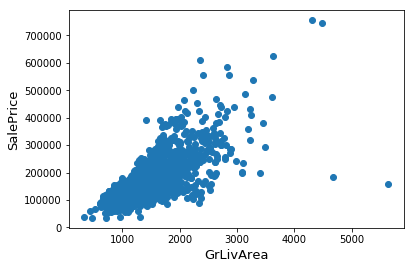

In [7]:
# Let's explore these outliers
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [8]:
df_train['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

#### Let's calculate IQR for GrLivArea
IQR = third quartile - first quartile

In [9]:
IQR = 1776.750000 - 1129.500000
print("IQR equal : {} ".format(IQR))

IQR equal : 647.25 


In [10]:
less = 1129.500000 - 1.5 * IQR
more = 1776.750000 +  1.5 * IQR 
print("Limit for left side equal : {} ".format(less))
print("Limit for ride side equal : {} ".format(more))

Limit for left side equal : 158.625 
Limit for ride side equal : 2747.625 


#### We've found all outliers, but we wouldn't delete because removing all of them may affect badly to our models if ever there were also outliers in the test data
#### We delete obvious outliers

In [11]:
# Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 3500)].index).reset_index(drop=True)

#### Now let's have a look at the train data and we will see that we lost a few examples (11). Then let's have a look at the graph.

In [12]:
print("The train data size is : {} ".format(df_train.shape))

The train data size is : (1454, 81) 


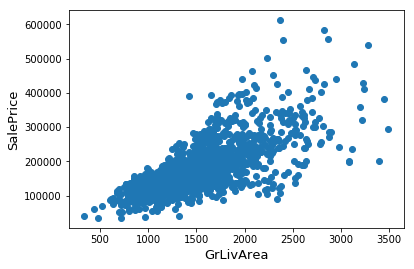

In [13]:
#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [14]:
# Get cat features
cat_features = df_train.select_dtypes(['object'])
df_train.drop(cat_features.columns, axis=1, inplace=True)
cat_features.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [15]:
# Get dummies
cat_features = pd.get_dummies(cat_features)
cat_features.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [16]:
# Join cat and df_train
df_train = df_train.join(cat_features)
df_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [17]:
y_train = df_train['SalePrice']
X_train = df_train
X_train = X_train.drop(['SalePrice'], axis=1)

In [18]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [19]:
X_train = X_train.iloc[:, 1:]
X_train = X_train.fillna(0)
features = X_train.select_dtypes(['float64'])
X_train = X_train.drop(features.columns, axis=1)

In [20]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Columns: 284 entries, MSSubClass to SaleCondition_Partial
dtypes: int64(33), uint8(251)
memory usage: 731.3 KB
None


### Let's go to choose model

In [24]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=2500)

Optimal number of features : 44


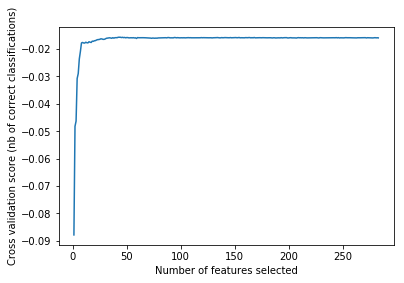

In [28]:
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='neg_mean_squared_log_error')
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [25]:
model = clf.fit(X_train, y_train)
importances = pd.DataFrame({'feature': X_train.columns,'importance': np.round(clf.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
# Plot important features
print(importances[:44])

                       importance
feature                          
BsmtUnfSF                   0.069
GrLivArea                   0.066
LotArea                     0.063
GarageArea                  0.050
1stFlrSF                    0.048
TotalBsmtSF                 0.045
BsmtFinSF1                  0.044
YearBuilt                   0.031
WoodDeckSF                  0.029
OpenPorchSF                 0.029
YearRemodAdd                0.027
MoSold                      0.026
2ndFlrSF                    0.024
OverallQual                 0.018
YrSold                      0.017
OverallCond                 0.014
EnclosedPorch               0.011
BedroomAbvGr                0.009
Neighborhood_CollgCr        0.009
TotRmsAbvGrd                0.008
ScreenPorch                 0.008
SaleCondition_Family        0.006
3SsnPorch                   0.006
BsmtFinSF2                  0.006
BsmtExposure_Gd             0.005
MSSubClass                  0.005
BsmtFullBath                0.005
Fireplaces    

In [26]:
list_importances = importances[:44].index.values.tolist() 

In [27]:
X_train = X_train[list_importances]

In [28]:
model = clf.fit(X_train, y_train)
X_train[list_importances].head()

,BsmtUnfSF,GrLivArea,LotArea,GarageArea,1stFlrSF,TotalBsmtSF,BsmtFinSF1,YearBuilt,WoodDeckSF,OpenPorchSF,...,Neighborhood_Edwards,SaleCondition_Abnorml,BsmtFinType1_GLQ,Neighborhood_BrkSide,BsmtFinType1_ALQ,BsmtFinType1_BLQ,RoofStyle_Hip,BsmtFinType1_Rec,BsmtExposure_Mn,HeatingQC_Ex
0,150,1710,8450,548,856,856,706,2003,0,61,...,0,0,1,0,0,0,0,0,0,1
1,284,1262,9600,460,1262,1262,978,1976,298,0,...,0,0,0,0,1,0,0,0,0,1
2,434,1786,11250,608,920,920,486,2001,0,42,...,0,0,1,0,0,0,0,0,1,1
3,540,1717,9550,642,961,756,216,1915,0,35,...,0,1,0,0,1,0,0,0,0,0
4,490,2198,14260,836,1145,1145,655,2000,192,84,...,0,0,1,0,0,0,0,0,0,1


In [29]:
ynew = model.predict(X_train)

#### Check out the mean squared log error

In [30]:
mean_squared_log_error(y_train, ynew) 

3.7773833896821772e-05

In [31]:
X_test = df_test

In [32]:
# Get cat features
cat_features = X_test.select_dtypes(['object'])
X_test.drop(cat_features.columns, axis=1, inplace=True)
# Get dummies
cat_features = pd.get_dummies(cat_features)
# Join cat and df_train
X_test = X_test.join(cat_features)
X_test = X_test.reset_index(drop=True)

In [33]:
X_test = X_test.iloc[:, 1:]
X_test = X_test.fillna(0)

In [34]:
features = df_test.select_dtypes(['float64'])
X_test = X_test.drop(features.columns, axis=1)

In [35]:
features = features.iloc[:, :].fillna(0.0).astype(int)

In [36]:
X_test = X_test.join(features)

In [37]:
X_test = X_test[list_importances]

In [38]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 44 columns):
BsmtUnfSF                1459 non-null int64
GrLivArea                1459 non-null int64
LotArea                  1459 non-null int64
GarageArea               1459 non-null int64
1stFlrSF                 1459 non-null int64
TotalBsmtSF              1459 non-null int64
BsmtFinSF1               1459 non-null int64
YearBuilt                1459 non-null int64
WoodDeckSF               1459 non-null int64
OpenPorchSF              1459 non-null int64
YearRemodAdd             1459 non-null int64
MoSold                   1459 non-null int64
2ndFlrSF                 1459 non-null int64
OverallQual              1459 non-null int64
YrSold                   1459 non-null int64
OverallCond              1459 non-null int64
EnclosedPorch            1459 non-null int64
BedroomAbvGr             1459 non-null int64
Neighborhood_CollgCr     1459 non-null uint8
TotRmsAbvGrd             1459 non-null

In [39]:
# Make prediction
prediction = model.predict(X_test)

In [40]:
# Write a solution on csv file
solution = pd.DataFrame({
        "Id": df_test['Id'],
        "SalePrice": prediction
    })
solution.to_csv('solution.csv', index=False)

My score is 0.13968 in Kaggle.